In [1]:
import os
from IPython.display import IFrame, HTML
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import pysal as ps
from shapely.geometry import Point, Polygon

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
gdal_data = os.environ['GDAL_DATA']

In [3]:
# os.environ
# os.chdir('Documents/repos/geo')
os.listdir()

['.git',
 '.gitattributes',
 '.gitignore',
 '.idea',
 '.ipynb_checkpoints',
 'arcgis.ipynb',
 'choropleth-map-example.png',
 'data',
 'geo_doodle.py',
 'my_functions_geo.py',
 'new_workflow.ipynb',
 'parking_Toronto.ipynb',
 'README.md',
 'Teranet_GTHA_DA_investigating_pins.ipynb',
 'Teranet_GTHA_DA_spatial_join.ipynb',
 'Teranet_GTHA_DA_workflow.ipynb']

In [3]:
from my_functions_geo import column_kde
from my_functions_geo import series_choropleth

In [2]:
# da_geo_source = 'https://opendata.arcgis.com/datasets/9d262f8a576842fbb2afbc8c51a64178_1.geojson'
da_geo_source = 'data/Profile_of_Income_by_Dissemination_Area__Greater_Toronto_Area_2016_Census.geojson'
da_income_gdf = gpd.read_file(da_geo_source)
print("GeoDataFrame 'da_income_gdf' with profile of income by dissimination areas created!")

GeoDataFrame 'da_income_gdf' with profile of income by dissimination areas created!


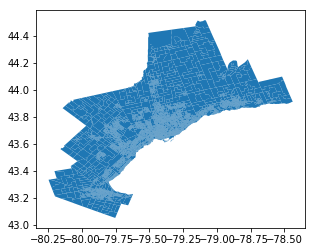

In [3]:
da_income_gdf.plot();

In [4]:
# verify the path to Teranet dataset
save_file_path = 'data/HHSaleHistory_cleaned_v0.9_GTHA_DA.csv'
# read Teranet dataset with a column containing Dissimination Areas id
teranet_da_df = pd.read_csv(save_file_path)
# drop unnecessary columns
teranet_da_df.drop(['Unnamed: 0', 'index'], axis=1, inplace=True)
# covert 'registration_date' to datetime data format
teranet_da_df['registration_date'] = pd.to_datetime(teranet_da_df['registration_date'])
teranet_da_df = teranet_da_df.set_index('registration_date')
teranet_da_df = teranet_da_df.sort_index()
print("Teranet sales data with Dissimination Areas info was loaded into DataFrame 'teranet_da_df'!")

Teranet sales data with Dissimination Areas info was loaded into DataFrame 'teranet_da_df'!


In [5]:
# group Teranet dataset by Dissimination Area id
da_groups = teranet_da_df.groupby(by='da_id')

In [6]:
# Make an aggregate (count of all records) from Teranet data
teranet_da_agg_count = pd.DataFrame(da_groups['x'].count())
print("Done!")

Done!


In [7]:
# key to be used for the JOIN in Teranet DA groups -- 'index'
teranet_da_agg_count.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182],
           dtype='int64', name='da_id', length=9168)

In [8]:
# Key to be used for the JOIN in gdf with Dissimination Areas -- column 'OBJECTID'
da_income_gdf[['OBJECTID']].sort_values(by='OBJECTID')

,OBJECTID
3000,1
3001,2
3002,3
3003,4
3004,5
3005,6
3006,7
3007,8
3008,9
3009,10


In [9]:
# perform the JOIN of Teranet aggregate with DA gdf
teranet_column_name = 'x'
new_column_name = 'teranet_sales_count'
# save projection information from GeoDataFrame with DAs
crs = da_income_gdf.crs
# JOIN Teranet aggregate to GeoDataFrame with DAs (produces a DataFrame)
teranet_da_gdf = pd.merge(teranet_da_agg_count,
                          da_income_gdf,
                          left_on=teranet_da_agg_count.index,
                          right_on=da_income_gdf['OBJECTID'])
# rename the column containing aggregate Teranet information
teranet_da_gdf.rename(columns={teranet_column_name:new_column_name}, inplace=True)
# convert DataFrame to GeoDataFrame
teranet_da_gdf = gpd.GeoDataFrame(teranet_da_gdf, 
                                  geometry=teranet_da_gdf['geometry'])
# add projection information to the new GeoDataFrame
teranet_da_gdf.crs = crs
print("Teranet data aggregate JOINED to GeoDataFrame with Dissimination Areas!")

Teranet data aggregate JOINED to GeoDataFrame with Dissimination Areas!


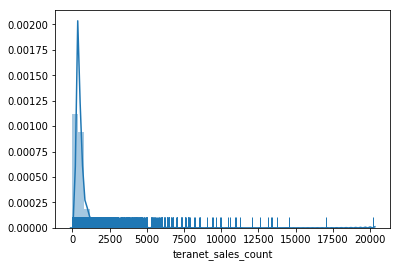

In [10]:
sns.distplot(teranet_da_gdf['teranet_sales_count'], rug=True)

In [11]:
teranet_da_gdf['teranet_sales_count'].sum()

6062853

# Spatial weights
One of the key pieces in spatial analysis are spatial weights matrices. These are structured sets of numbers that formalize geographical relationships between the observations in a dataset. Essentially, a spatial weights matrix of a given geography is a positive definite matrix of dimensions $N$ by $N$, where $N$ is the total number of observations:

$W = \left(\begin{array}{cccc}
0 & w_{12} & \dots & w_{1N} \\
w_{21} & \ddots & w_{ij} & \vdots \\
\vdots & w_{ji} & 0 & \vdots \\
w_{N1} & \dots & \dots & 0 
\end{array} \right)$

where each cell $w_{ij}$ contains a value that represents the degree of spatial contact or interaction between observations $i$ and $j$. A fundamental concept in this context is that of *neighbor* and *neighborhood*. By convention, elements in the diagonal ($w_{ij}$) are set to zero. A *neighbor* of a given observation $i$ is another observation with which $i$ has some degree of connection. In terms of $W$, $i$ and $j$ are thus neighbors if $w_{ij} > 0$. Following this logic, the neighborhood of $i$ will be the set of observations in the system with which it has certain connection, or those observations with a weight greater than zero.

There are several ways to create such matrices, and many more to transform them so they contain an accurate representation that aligns with the way we understand spatial interactions between the elements of a system. 

In [12]:
w_queen = ps.lib.weights.Queen.from_dataframe(teranet_da_gdf)
w_queen.remap_ids(teranet_da_gdf.index)
w_queen

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\contiguity.py:184: UserWarning: There is one disconnected observation (no neighbors).
Island id: 1298
  W.__init__(self, neighbors, ids=ids, **kw)


Queen neighbours:
Number of observations 9168
Average number of neighbors 6.422993019197207
Min number of neighbors 0
Max number of neighbors 31
Islands (observations disconnected) [1298]


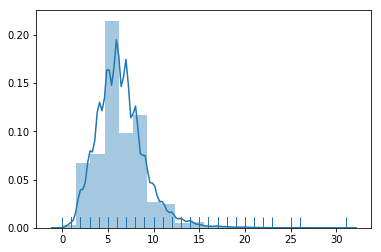

In [13]:
# Number of observations
print("Queen neighbours:")
print("Number of observations", 
      w_queen.n)
print("Average number of neighbors", 
      w_queen.mean_neighbors)
print("Min number of neighbors", 
      w_queen.min_neighbors)
print("Max number of neighbors", 
      w_queen.max_neighbors)
print("Islands (observations disconnected)", 
      w_queen.islands)
queen_card = pd.Series(w_queen.cardinalities)
sns.distplot(queen_card, rug=True, bins=20)

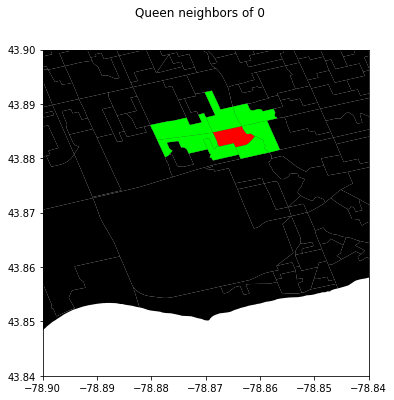

In [14]:
focus_da_id = 0
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
teranet_da_gdf.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets!!!
focus = teranet_da_gdf.loc[[focus_da_id], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = teranet_da_gdf.loc[list(w_queen[focus_da_id].keys())]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Title
f.suptitle("Queen neighbors of {0}".format(focus_da_id))
# Style and display on screen
ax.set_ylim(43.84, 43.9)
ax.set_xlim(-78.9, -78.84)
# ax.set_ylim(focus.centroid.y - 0.5, focus.centroid.y + 0.5)
# ax.set_xlim(focus.centroid.x - 0.5, focus.centroid.x + 0.5)
plt.show()

In [15]:
# KNN neighbours
k = 20
knn = ps.lib.weights.KNN.from_dataframe(teranet_da_gdf,
                                          k=k)
knn.remap_ids(teranet_da_gdf.index)
knn

KNN neighbours (k=20):
Number of observations 9168
Average number of neighbors 20.0
Min number of neighbors 20
Max number of neighbors 20
Islands (observations disconnected) []


C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


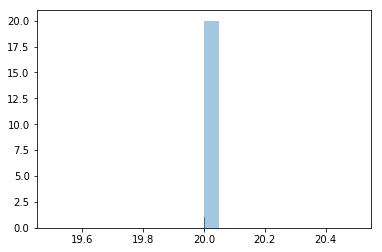

In [16]:
print("KNN neighbours (k={0}):"
      .format(k))
print("Number of observations", 
      knn.n)
print("Average number of neighbors", 
      knn.mean_neighbors)
print("Min number of neighbors", 
      knn.min_neighbors)
print("Max number of neighbors", 
      knn.max_neighbors)
print("Islands (observations disconnected)", 
      knn.islands)
knn_card = pd.Series(knn.cardinalities)
sns.distplot(knn_card, rug=True, bins=20)

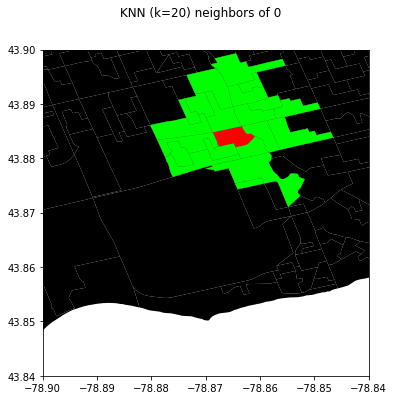

In [17]:
focus_da_id = 0
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
teranet_da_gdf.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets!!!
focus = teranet_da_gdf.loc[[focus_da_id], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = teranet_da_gdf.loc[list(knn[focus_da_id].keys())]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Title
f.suptitle("KNN (k={0}) neighbors of {1}"
           .format(k, focus_da_id))
# Style and display on screen
ax.set_ylim(43.84, 43.9)
ax.set_xlim(-78.9, -78.84)
# ax.set_ylim(focus.centroid.y - 0.5, focus.centroid.y + 0.5)
# ax.set_xlim(focus.centroid.x - 0.5, focus.centroid.x + 0.5)
plt.show()

In [18]:
# Distance band neighbours (binary)
dist = 1000 # buffer in m
dist_deg = dist / (1000 * 112.32) # convert to degrees of WGS 84
w_dist1kmB = ps.lib.weights.DistanceBand.from_dataframe(teranet_da_gdf, 
                                                        dist_deg, 
                                                        binary=True)
w_dist1kmB

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 549 disconnected observations 
  Island ids: 38, 39, 61, 85, 96, 106, 116, 117, 144, 145, 149, 154, 155, 161, 162, 163, 164, 165, 166, 167, 168, 204, 205, 206, 217, 218, 219, 229, 230, 231, 232, 233, 234, 235, 240, 314, 356, 413, 438, 472, 498, 507, 524, 536, 556, 558, 559, 560, 597, 598, 599, 629, 630, 631, 632, 633, 634, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 695, 696, 697, 698, 699, 710, 711, 738, 739, 740, 741, 742, 743, 744, 746, 766, 767, 768, 769, 770, 809, 810, 811, 812, 813, 836, 837, 838, 839, 840, 841, 843, 914, 915, 916, 955, 956, 989, 990, 991, 992, 996, 997, 1013, 1014, 1019, 1039, 1054, 1055, 1062, 1075, 1076, 1077, 1078, 1089, 1090, 1100, 1107, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1131, 1186, 1194, 1195, 1219, 1220, 1221, 1237, 1238, 1245, 1254, 1255, 1275, 1276, 1277, 1278, 1291, 1298, 1334, 1335, 1336, 1356, 1365, 1373, 1379, 1382, 13

Distance band neighbours (binary, dist=1000m):
Number of observations 9168
Average number of neighbors 12.836387434554974
Min number of neighbors 0
Max number of neighbors 58
Islands (observations disconnected) [38, 39, 61, 85, 96, 106, 116, 117, 144, 145, 149, 154, 155, 161, 162, 163, 164, 165, 166, 167, 168, 204, 205, 206, 217, 218, 219, 229, 230, 231, 232, 233, 234, 235, 240, 314, 356, 413, 438, 472, 498, 507, 524, 536, 556, 558, 559, 560, 597, 598, 599, 629, 630, 631, 632, 633, 634, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 695, 696, 697, 698, 699, 710, 711, 738, 739, 740, 741, 742, 743, 744, 746, 766, 767, 768, 769, 770, 809, 810, 811, 812, 813, 836, 837, 838, 839, 840, 841, 843, 914, 915, 916, 955, 956, 989, 990, 991, 992, 996, 997, 1013, 1014, 1019, 1039, 1054, 1055, 1062, 1075, 1076, 1077, 1078, 1089, 1090, 1100, 1107, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1131, 1186, 1194, 1195, 1219, 1220, 1221, 1237, 1238, 1245, 1254, 1255, 1275, 1276, 1277, 1278, 1291

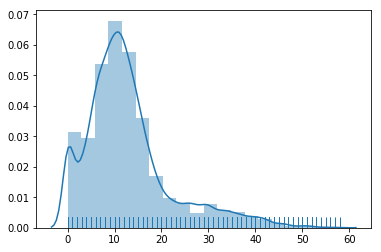

In [19]:
print("Distance band neighbours (binary, dist={0}m):"
      .format(dist))
print("Number of observations", 
      w_dist1kmB.n)
print("Average number of neighbors", 
      w_dist1kmB.mean_neighbors)
print("Min number of neighbors", 
      w_dist1kmB.min_neighbors)
print("Max number of neighbors", 
      w_dist1kmB.max_neighbors)
print("Islands (observations disconnected)", 
      w_dist1kmB.islands)
distB_card = pd.Series(w_dist1kmB.cardinalities)
sns.distplot(distB_card, rug=True, bins=20)

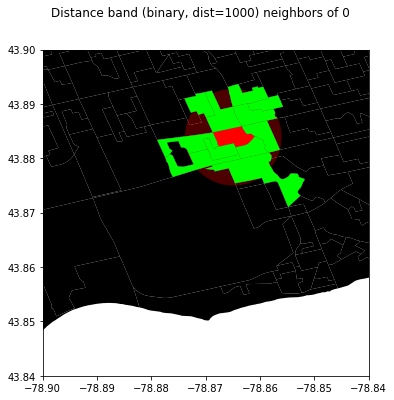

In [20]:
focus_da_id = 0
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
teranet_da_gdf.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets!!!
focus = teranet_da_gdf.loc[[focus_da_id], ['geometry']]
focus.centroid.buffer(dist_deg).plot(ax=ax, alpha=0.3, color='red')
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = teranet_da_gdf.loc[list(w_dist1kmB[focus_da_id].keys())]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Title
f.suptitle("Distance band (binary, dist={0}) neighbors of {1}"
           .format(dist, focus_da_id))
# Style and display on screen
ax.set_ylim(43.84, 43.9)
ax.set_xlim(-78.9, -78.84)
# ax.set_ylim(focus.centroid.y - 0.5, focus.centroid.y + 0.5)
# ax.set_xlim(focus.centroid.x - 0.5, focus.centroid.x + 0.5)
plt.show()

In [21]:
# Distance band neighbours (binary)
dist = 2000 # buffer in m
dist_deg = dist / (1000 * 112.32) # convert to degrees of WGS 84
w_dist2kmB = ps.lib.weights.DistanceBand.from_dataframe(teranet_da_gdf, 
                                                        dist_deg, 
                                                        binary=True)
w_dist2kmB

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 325 disconnected observations 
  Island ids: 38, 85, 106, 116, 144, 145, 149, 154, 155, 161, 162, 163, 165, 166, 167, 168, 204, 205, 206, 217, 218, 230, 231, 240, 472, 524, 536, 559, 560, 597, 598, 630, 631, 634, 645, 647, 648, 649, 650, 652, 653, 654, 655, 656, 696, 698, 710, 711, 738, 739, 740, 741, 742, 743, 766, 769, 770, 809, 810, 811, 812, 813, 836, 837, 838, 839, 840, 914, 915, 916, 955, 956, 989, 990, 991, 992, 996, 1013, 1039, 1054, 1055, 1076, 1077, 1078, 1090, 1100, 1107, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1186, 1219, 1220, 1221, 1255, 1276, 1291, 1334, 1335, 1336, 1356, 1365, 1373, 1379, 1382, 1405, 1408, 1503, 1508, 1516, 1532, 1541, 1682, 1691, 1724, 1751, 1757, 1758, 1790, 1816, 1817, 1840, 1856, 1857, 1869, 1870, 1886, 1887, 1888, 1899, 1917, 1918, 1928, 1930, 1933, 1962, 1963, 1975, 1991, 2022, 2055, 2082, 2094, 2095, 2096, 2097, 2098, 2132, 2140, 2

Distance band neighbours (binary, dist=2000m):
Number of observations 9168
Average number of neighbors 46.84424083769633
Min number of neighbors 0
Max number of neighbors 175
Islands (observations disconnected) [38, 85, 106, 116, 144, 145, 149, 154, 155, 161, 162, 163, 165, 166, 167, 168, 204, 205, 206, 217, 218, 230, 231, 240, 472, 524, 536, 559, 560, 597, 598, 630, 631, 634, 645, 647, 648, 649, 650, 652, 653, 654, 655, 656, 696, 698, 710, 711, 738, 739, 740, 741, 742, 743, 766, 769, 770, 809, 810, 811, 812, 813, 836, 837, 838, 839, 840, 914, 915, 916, 955, 956, 989, 990, 991, 992, 996, 1013, 1039, 1054, 1055, 1076, 1077, 1078, 1090, 1100, 1107, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1186, 1219, 1220, 1221, 1255, 1276, 1291, 1334, 1335, 1336, 1356, 1365, 1373, 1379, 1382, 1405, 1408, 1503, 1508, 1516, 1532, 1541, 1682, 1691, 1724, 1751, 1757, 1758, 1790, 1816, 1817, 1840, 1856, 1857, 1869, 1870, 1886, 1887, 1888, 1899, 1917, 1918, 1928, 1930, 1933, 1962, 1963, 1975, 1991, 202

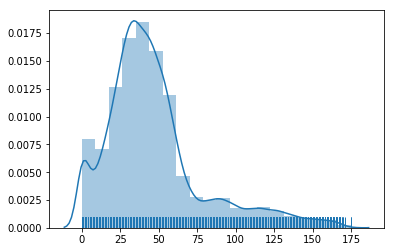

In [22]:
print("Distance band neighbours (binary, dist={0}m):"
      .format(dist))
print("Number of observations", 
      w_dist2kmB.n)
print("Average number of neighbors", 
      w_dist2kmB.mean_neighbors)
print("Min number of neighbors", 
      w_dist2kmB.min_neighbors)
print("Max number of neighbors", 
      w_dist2kmB.max_neighbors)
print("Islands (observations disconnected)", 
      w_dist2kmB.islands)
distB2_card = pd.Series(w_dist2kmB.cardinalities)
sns.distplot(distB2_card, rug=True, bins=20)

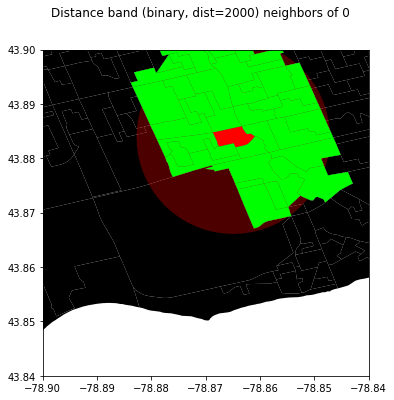

In [23]:
focus_da_id = 0
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
teranet_da_gdf.plot(ax=ax, facecolor='k', linewidth=0.1)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets!!!
focus = teranet_da_gdf.loc[[focus_da_id], ['geometry']]
focus.centroid.buffer(dist_deg).plot(ax=ax, alpha=0.3, color='red')
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)
# Plot neighbors
neis = teranet_da_gdf.loc[list(w_dist2kmB[focus_da_id].keys())]
neis.plot(ax=ax, facecolor='lime', linewidth=0)
# Title
f.suptitle("Distance band (binary, dist={0}) neighbors of {1}"
           .format(dist, focus_da_id))
# Style and display on screen
ax.set_ylim(43.84, 43.9)
ax.set_xlim(-78.9, -78.84)
# ax.set_ylim(focus.centroid.y - 0.5, focus.centroid.y + 0.5)
# ax.set_xlim(focus.centroid.x - 0.5, focus.centroid.x + 0.5)
plt.show()

In [24]:
# Distance band neighbours (continuous)
dist = 1000 # buffer in m
dist_deg = dist / (1000 * 112.32) # convert to degrees of WGS 84
w_dist1kmC = ps.lib.weights.DistanceBand.from_dataframe(teranet_da_gdf, 
                                                        dist_deg, 
                                                        binary=False)
w_dist1kmC

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 549 disconnected observations 
  Island ids: 38, 39, 61, 85, 96, 106, 116, 117, 144, 145, 149, 154, 155, 161, 162, 163, 164, 165, 166, 167, 168, 204, 205, 206, 217, 218, 219, 229, 230, 231, 232, 233, 234, 235, 240, 314, 356, 413, 438, 472, 498, 507, 524, 536, 556, 558, 559, 560, 597, 598, 599, 629, 630, 631, 632, 633, 634, 645, 646, 647, 648, 649, 650, 652, 653, 654, 655, 656, 695, 696, 697, 698, 699, 710, 711, 738, 739, 740, 741, 742, 743, 744, 746, 766, 767, 768, 769, 770, 809, 810, 811, 812, 813, 836, 837, 838, 839, 840, 841, 843, 914, 915, 916, 955, 956, 989, 990, 991, 992, 996, 997, 1013, 1014, 1019, 1039, 1054, 1055, 1062, 1075, 1076, 1077, 1078, 1089, 1090, 1100, 1107, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1131, 1186, 1194, 1195, 1219, 1220, 1221, 1237, 1238, 1245, 1254, 1255, 1275, 1276, 1277, 1278, 1291, 1298, 1334, 1335, 1336, 1356, 1365, 1373, 1379, 1382, 13

In [25]:
# Distance band neighbours (continuous)
dist = 2000 # buffer in m
dist_deg = dist / (1000 * 112.32) # convert to degrees of WGS 84
w_dist2kmC = ps.lib.weights.DistanceBand.from_dataframe(teranet_da_gdf, 
                                                        dist_deg, 
                                                        binary=False)
w_dist2kmC

C:\ProgramData\Anaconda3\envs\gds\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 325 disconnected observations 
  Island ids: 38, 85, 106, 116, 144, 145, 149, 154, 155, 161, 162, 163, 165, 166, 167, 168, 204, 205, 206, 217, 218, 230, 231, 240, 472, 524, 536, 559, 560, 597, 598, 630, 631, 634, 645, 647, 648, 649, 650, 652, 653, 654, 655, 656, 696, 698, 710, 711, 738, 739, 740, 741, 742, 743, 766, 769, 770, 809, 810, 811, 812, 813, 836, 837, 838, 839, 840, 914, 915, 916, 955, 956, 989, 990, 991, 992, 996, 1013, 1039, 1054, 1055, 1076, 1077, 1078, 1090, 1100, 1107, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1186, 1219, 1220, 1221, 1255, 1276, 1291, 1334, 1335, 1336, 1356, 1365, 1373, 1379, 1382, 1405, 1408, 1503, 1508, 1516, 1532, 1541, 1682, 1691, 1724, 1751, 1757, 1758, 1790, 1816, 1817, 1840, 1856, 1857, 1869, 1870, 1886, 1887, 1888, 1899, 1917, 1918, 1928, 1930, 1933, 1962, 1963, 1975, 1991, 2022, 2055, 2082, 2094, 2095, 2096, 2097, 2098, 2132, 2140, 2

## Standardizing `W` matrices

In the context of many spatial analysis techniques, a spatial weights matrix with raw values (e.g. ones and zeros for the binary case) is not always the best suiting one for analysis and some sort of transformation is required. This implies modifying each weight so they conform to certain rules. `PySAL` has transformations baked right into the `W` object, so it is possible to check the state of an object as well as to modify it.

`PySAL` supports the following transformations:

* `O`: original, returning the object to the initial state.
* `B`: binary, with every neighbor having assigned a weight of one.
* `R`: row, with all the neighbors of a given observation adding up to one.
* `V`: variance stabilizing, with the sum of all the weights being constrained to the number of observations.

## Spatial Lag

One of the most direct applications of spatial weight matrices is the so-called *spatial lag*. The spatial lag of a given variable is the product of a spatial weight matrix and the variable itself:

$$Y_{sl} = W Y$$

where $Y$ is a Nx1 vector with the values of the variable. Recall that the product of a matrix and a vector equals the sum of a row by column element multiplication for the resulting value of a given row. In terms of the spatial lag:

$$y_{sl-i} = \displaystyle \sum_j w_{ij} y_j$$

If we are using row-standardized weights, $w_{ij}$ becomes a proportion between zero and one, and $y_{sl-i}$ can be seen as the average value of $Y$ in the neighborhood of $i$.

The spatial lag is a key element of many spatial analysis techniques and, as such, it is fully supported in `PySAL`. To compute the spatial lag of a given variable:

In [27]:
column = 'teranet_sales_count'
# Row-standardize the weight matrix
w_queen.transform = 'R'
# Compute spatial lag of `imd_score`
w_queen_score = ps.lib.weights.lag_spatial(w_queen, 
                                           teranet_da_gdf[column])
w_queen.transform = 'O'
teranet_da_gdf['w_queen_score'] = w_queen_score
# Print the first five elements
w_queen_score[:5]

('WARNING: ', 1298, ' is an island (no neighbors)')


array([408.        , 516.        , 600.        , 619.71428571,
       595.75      ])

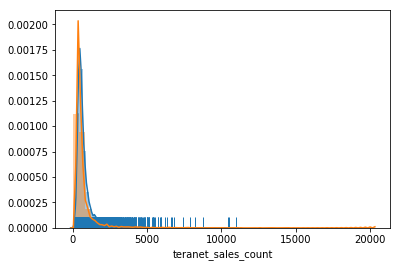

In [28]:
sns.distplot(w_queen_score, rug=True)
sns.distplot(teranet_da_gdf['teranet_sales_count'])

In [29]:
# Row-standardize the weight matrix
knn.transform = 'R'
# Compute spatial lag of `imd_score`
knn_score = ps.lib.weights.lag_spatial(knn, 
                                       teranet_da_gdf[column])
knn.transform = 'O'
teranet_da_gdf['w_knn_score'] = knn_score
# Print the first five elements
knn_score[:5]

array([443.15, 404.55, 458.85, 473.05, 436.05])

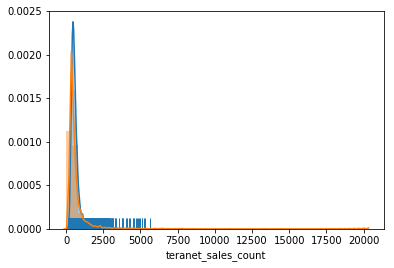

In [30]:
sns.distplot(knn_score, rug=True)
sns.distplot(teranet_da_gdf['teranet_sales_count'])

In [31]:
# Row-standardize the weight matrix
w_dist1kmB.transform = 'R'
# Compute spatial lag of `imd_score`
dist1kmB_score = ps.lib.weights.lag_spatial(w_dist1kmB, 
                                            teranet_da_gdf[column])
w_dist1kmB.transform = 'O'
teranet_da_gdf['w_dist_1kmB_score'] = dist1kmB_score
# Print the first five elements
dist1kmB_score[:5]

('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 61, ' is an island (no neighbors)')
('WARNING: ', 85, ' is an island (no neighbors)')
('WARNING: ', 96, ' is an island (no neighbors)')
('WARNING: ', 106, ' is an island (no neighbors)')
('WARNING: ', 116, ' is an island (no neighbors)')
('WARNING: ', 117, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 145, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')
('WARNING: ', 154, ' is an island (no neighbors)')
('WARNING: ', 155, ' is an island (no neighbors)')
('WARNING: ', 161, ' is an island (no neighbors)')
('WARNING: ', 162, ' is an island (no neighbors)')
('WARNING: ', 163, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 165, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 167, ' is an island (n

array([450.63636364, 454.625     , 430.66666667, 498.4       ,
       437.2       ])

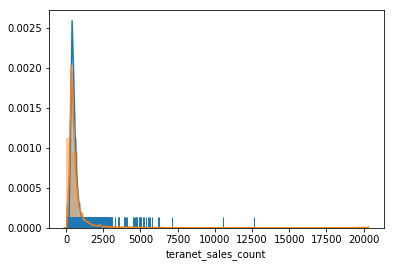

In [32]:
sns.distplot(dist1kmB_score, rug=True)
sns.distplot(teranet_da_gdf['teranet_sales_count'])

In [33]:
# Row-standardize the weight matrix
w_dist2kmB.transform = 'R'
# Compute spatial lag of `imd_score`
dist2kmB_score = ps.lib.weights.lag_spatial(w_dist2kmB, 
                                            teranet_da_gdf[column])
w_dist2kmB.transform = 'O'
teranet_da_gdf['w_dist_2kmB_score'] = dist2kmB_score
# Print the first five elements
dist2kmB_score[:5]

('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 85, ' is an island (no neighbors)')
('WARNING: ', 106, ' is an island (no neighbors)')
('WARNING: ', 116, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 145, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')
('WARNING: ', 154, ' is an island (no neighbors)')
('WARNING: ', 155, ' is an island (no neighbors)')
('WARNING: ', 161, ' is an island (no neighbors)')
('WARNING: ', 162, ' is an island (no neighbors)')
('WARNING: ', 163, ' is an island (no neighbors)')
('WARNING: ', 165, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 167, ' is an island (no neighbors)')
('WARNING: ', 168, ' is an island (no neighbors)')
('WARNING: ', 204, ' is an island (no neighbors)')
('WARNING: ', 205, ' is an island (no neighbors)')
('WARNING: ', 206, ' is an island (no neighbors)')
('WARNING: ', 217, ' is an island

array([471.55263158, 432.17142857, 439.82758621, 468.75      ,
       514.83333333])

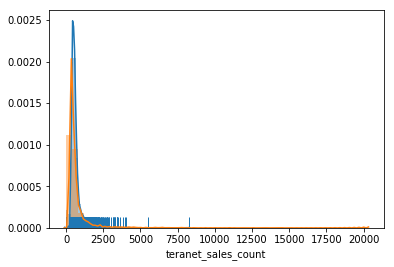

In [34]:
sns.distplot(dist2kmB_score, rug=True)
sns.distplot(teranet_da_gdf['teranet_sales_count'])

In [35]:
# Row-standardize the weight matrix
w_dist1kmC.transform = 'R'
# Compute spatial lag of `imd_score`
dist1kmC_score = ps.lib.weights.lag_spatial(w_dist1kmC, 
                                            teranet_da_gdf[column])
w_dist1kmC.transform = 'O'
teranet_da_gdf['w_dist_1kmC_score'] = dist1kmC_score
# Print the first five elements
dist1kmC_score[:5]

('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 61, ' is an island (no neighbors)')
('WARNING: ', 85, ' is an island (no neighbors)')
('WARNING: ', 96, ' is an island (no neighbors)')
('WARNING: ', 106, ' is an island (no neighbors)')
('WARNING: ', 116, ' is an island (no neighbors)')
('WARNING: ', 117, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 145, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')
('WARNING: ', 154, ' is an island (no neighbors)')
('WARNING: ', 155, ' is an island (no neighbors)')
('WARNING: ', 161, ' is an island (no neighbors)')
('WARNING: ', 162, ' is an island (no neighbors)')
('WARNING: ', 163, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 165, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 167, ' is an island (n

array([435.82062467, 450.10096808, 475.69079387, 529.14760732,
       437.25559193])

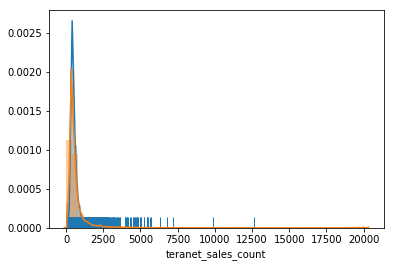

In [36]:
sns.distplot(dist1kmC_score, rug=True)
sns.distplot(teranet_da_gdf['teranet_sales_count'])

In [37]:
# Row-standardize the weight matrix
w_dist2kmC.transform = 'R'
# Compute spatial lag of `imd_score`
dist2kmC_score = ps.lib.weights.lag_spatial(w_dist2kmC, 
                                            teranet_da_gdf[column])
w_dist2kmC.transform = 'O'
teranet_da_gdf['w_dist_2kmC_score'] = dist2kmC_score
# Print the first five elements
dist2kmC_score[:5]

('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 85, ' is an island (no neighbors)')
('WARNING: ', 106, ' is an island (no neighbors)')
('WARNING: ', 116, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 145, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')
('WARNING: ', 154, ' is an island (no neighbors)')
('WARNING: ', 155, ' is an island (no neighbors)')
('WARNING: ', 161, ' is an island (no neighbors)')
('WARNING: ', 162, ' is an island (no neighbors)')
('WARNING: ', 163, ' is an island (no neighbors)')
('WARNING: ', 165, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 167, ' is an island (no neighbors)')
('WARNING: ', 168, ' is an island (no neighbors)')
('WARNING: ', 204, ' is an island (no neighbors)')
('WARNING: ', 205, ' is an island (no neighbors)')
('WARNING: ', 206, ' is an island (no neighbors)')
('WARNING: ', 217, ' is an island

array([453.67203245, 432.80715858, 456.4760421 , 481.9061429 ,
       487.14891068])

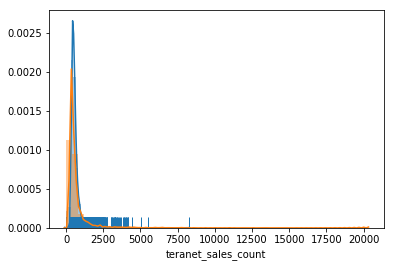

In [38]:
sns.distplot(dist2kmC_score, rug=True)
sns.distplot(teranet_da_gdf['teranet_sales_count'])

## Moran Plot

The Moran Plot is a graphical way to start exploring the concept of spatial autocorrelation, and it is a good application of spatial weight matrices and the spatial lag. In essence, it is a standard scatter plot in which a given variable is plotted against *its own* spatial lag. Usually, a fitted line is added to include more information.

In order to easily compare different scatter plots and spot outlier observations, it is common practice to standardize the values of the variable before computing its spatial lag and plotting it. This can be accomplished by substracting the average value and dividing the result by the standard deviation:

$z_i = \dfrac{y - \bar{y}}{\sigma_y}$

where $z_i$ is the standardized version of $y_i$, $\bar{y}$ is the average of the variable, and $\sigma$ its standard deviation.

Creating a standardized Moran Plot implies that average values are centered in the plot (as they are zero when standardized) and dispersion is expressed in standard deviations, with the rule of thumb of values greater or smaller than two standard deviations being *outliers*. A standardized Moran Plot also partitions the space into four quadrants that represent different situations:

1. High-High (*HH*): values above average surrounded by values above average.
1. Low-Low (*LL*): values below average surrounded by values below average.
1. High-Low (*HL*): values above average surrounded by values below average.
1. Low-High (*LH*): values below average surrounded by values above average.

In [26]:
column = 'teranet_sales_count'
# Standardize values
std_val = (teranet_da_gdf[column] - teranet_da_gdf[column].mean()) / teranet_da_gdf[column].std()
print("Done!")

Done!


('WARNING: ', 1298, ' is an island (no neighbors)')


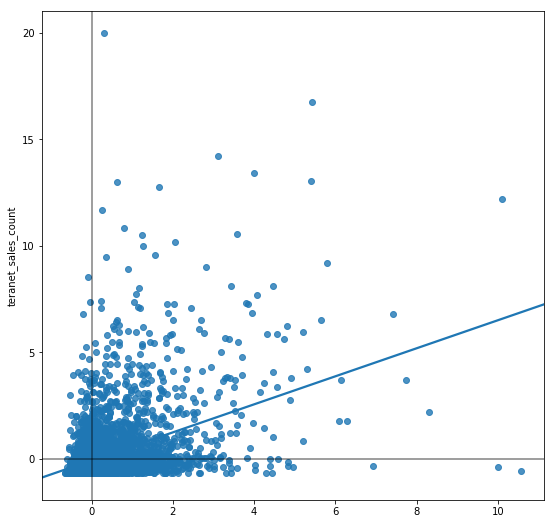

In [27]:
# Compute the spatial lag of the standardized version and save is as a 
# Series indexed as the original variable
w_queen.transform = 'R'
std_w_queen_score = pd.Series(ps.lib.weights.lag_spatial(w_queen, std_val), 
                              index=std_val.index)
# Setup the figure and axis
# noinspection PyRedeclaration
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_w_queen_score, 
            y=std_val, 
            ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

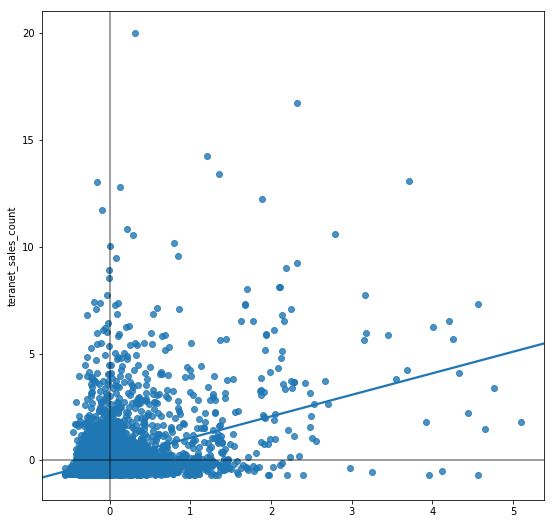

In [28]:
# Compute the spatial lag of the standardized version and save is as a 
# Series indexed as the original variable
knn.transform = 'R'
std_w_knn_score = pd.Series(ps.lib.weights.lag_spatial(knn, std_val), 
                            index=std_val.index)
# Setup the figure and axis
# noinspection PyRedeclaration
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_w_knn_score, 
            y=std_val, 
            ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 61, ' is an island (no neighbors)')
('WARNING: ', 85, ' is an island (no neighbors)')
('WARNING: ', 96, ' is an island (no neighbors)')
('WARNING: ', 106, ' is an island (no neighbors)')
('WARNING: ', 116, ' is an island (no neighbors)')
('WARNING: ', 117, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 145, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')
('WARNING: ', 154, ' is an island (no neighbors)')
('WARNING: ', 155, ' is an island (no neighbors)')
('WARNING: ', 161, ' is an island (no neighbors)')
('WARNING: ', 162, ' is an island (no neighbors)')
('WARNING: ', 163, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 165, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 167, ' is an island (n

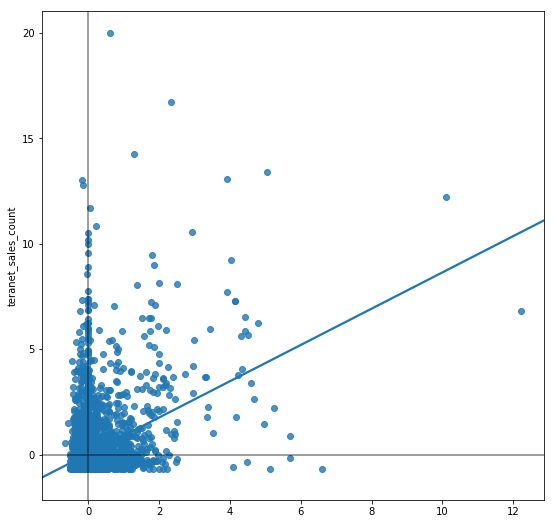

In [29]:
# Compute the spatial lag of the standardized version and save is as a 
# Series indexed as the original variable
w_dist1kmB.transform = 'R'
std_w_dist1kmB_score = pd.Series(ps.lib.weights.lag_spatial(w_dist1kmB, std_val), 
                                 index=std_val.index)
# Setup the figure and axis
# noinspection PyRedeclaration
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_w_dist1kmB_score, 
            y=std_val, 
            ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 85, ' is an island (no neighbors)')
('WARNING: ', 106, ' is an island (no neighbors)')
('WARNING: ', 116, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 145, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')
('WARNING: ', 154, ' is an island (no neighbors)')
('WARNING: ', 155, ' is an island (no neighbors)')
('WARNING: ', 161, ' is an island (no neighbors)')
('WARNING: ', 162, ' is an island (no neighbors)')
('WARNING: ', 163, ' is an island (no neighbors)')
('WARNING: ', 165, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 167, ' is an island (no neighbors)')
('WARNING: ', 168, ' is an island (no neighbors)')
('WARNING: ', 204, ' is an island (no neighbors)')
('WARNING: ', 205, ' is an island (no neighbors)')
('WARNING: ', 206, ' is an island (no neighbors)')
('WARNING: ', 217, ' is an island

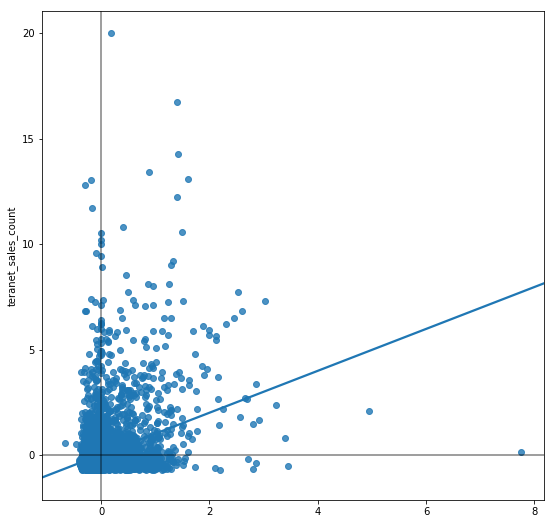

In [30]:
# Compute the spatial lag of the standardized version and save is as a 
# Series indexed as the original variable
w_dist2kmB.transform = 'R'
std_w_dist2kmB_score = pd.Series(ps.lib.weights.lag_spatial(w_dist2kmB, std_val), 
                                 index=std_val.index)
# Setup the figure and axis
# noinspection PyRedeclaration
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_w_dist2kmB_score, 
            y=std_val, 
            ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 61, ' is an island (no neighbors)')
('WARNING: ', 85, ' is an island (no neighbors)')
('WARNING: ', 96, ' is an island (no neighbors)')
('WARNING: ', 106, ' is an island (no neighbors)')
('WARNING: ', 116, ' is an island (no neighbors)')
('WARNING: ', 117, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 145, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')
('WARNING: ', 154, ' is an island (no neighbors)')
('WARNING: ', 155, ' is an island (no neighbors)')
('WARNING: ', 161, ' is an island (no neighbors)')
('WARNING: ', 162, ' is an island (no neighbors)')
('WARNING: ', 163, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 165, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 167, ' is an island (n

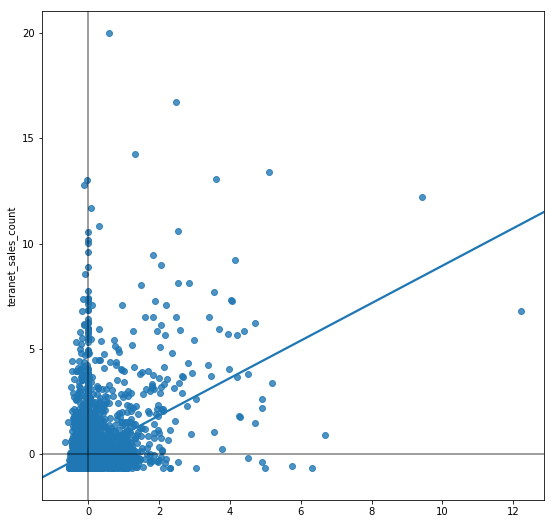

In [31]:
# Compute the spatial lag of the standardized version and save is as a 
# Series indexed as the original variable
w_dist1kmC.transform = 'R'
std_w_dist1kmC_score = pd.Series(ps.lib.weights.lag_spatial(w_dist1kmC, std_val), 
                                 index=std_val.index)
# Setup the figure and axis
# noinspection PyRedeclaration
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_w_dist1kmC_score, 
            y=std_val, 
            ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 85, ' is an island (no neighbors)')
('WARNING: ', 106, ' is an island (no neighbors)')
('WARNING: ', 116, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 145, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')
('WARNING: ', 154, ' is an island (no neighbors)')
('WARNING: ', 155, ' is an island (no neighbors)')
('WARNING: ', 161, ' is an island (no neighbors)')
('WARNING: ', 162, ' is an island (no neighbors)')
('WARNING: ', 163, ' is an island (no neighbors)')
('WARNING: ', 165, ' is an island (no neighbors)')
('WARNING: ', 166, ' is an island (no neighbors)')
('WARNING: ', 167, ' is an island (no neighbors)')
('WARNING: ', 168, ' is an island (no neighbors)')
('WARNING: ', 204, ' is an island (no neighbors)')
('WARNING: ', 205, ' is an island (no neighbors)')
('WARNING: ', 206, ' is an island (no neighbors)')
('WARNING: ', 217, ' is an island

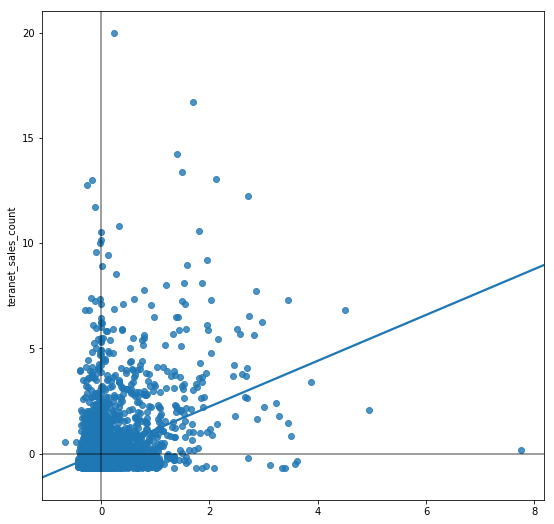

In [32]:
# Compute the spatial lag of the standardized version and save is as a 
# Series indexed as the original variable
w_dist2kmC.transform = 'R'
std_w_dist2kmC_score = pd.Series(ps.lib.weights.lag_spatial(w_dist2kmC, std_val), 
                                 index=std_val.index)
# Setup the figure and axis
# noinspection PyRedeclaration
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_w_dist2kmC_score, 
            y=std_val, 
            ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [35]:
teranet_da_gdf.crs

{'init': 'epsg:4326'}

In [21]:
from pyproj import Proj
Proj('+init=epsg:2193', preserve_flags=True)

RuntimeError: b'no arguments in initialization list'

In [24]:
Pr0oj({'init': 'epsg:2193', 'no_defs': True}, preserve_flags=True)

RuntimeError: b'no arguments in initialization list'

In [22]:
data = teranet_da_gdf.to_crs(epsg=27700)
data.crs

RuntimeError: b'no arguments in initialization list'

In [61]:
# combine values in columns 'x' and 'y' into a POINT geometry object
geometry = [Point(xy) for xy in zip(teranet_da_df['x'], teranet_da_df['y'])]
# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
point_data = gpd.GeoDataFrame(teranet_da_df, geometry=geometry)
print("Geometry generated from 'x' and 'y' pairs, GeoDataFrame created!")

Geometry generated from 'x' and 'y' pairs, GeoDataFrame created!


In [67]:
%%time
# add CRS for WGS84 (lat-long) to GeoDataFrame 'sales_data_geo'
point_data.crs = {'proj': 'latlong', 
                  'ellps': 'WGS84', 
                  'datum': 'WGS84', 
                  'no_defs': True}
points_data = point_data.to_crs(epsg=27700)
point_data.crs

Wall time: 6min 2s


In [ ]:
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
data.plot(ax=ax, facecolor='k', linewidth=0.1)
# plot point data
point_data.head(1000).plot(ax=ax)
# Title
f.suptitle("Sample of Teranet sales with DAs")
# Style and display on screen
y_lim = 3056000
x_lim = -5130000
step = 5000
# ax.set_ylim(y_lim, y_lim + step)
# ax.set_xlim(x_lim, x_lim + step)
plt.show()

In [66]:
%%time
w_point_dist1kmC = ps.lib.weights.DistanceBand.from_dataframe(point_data, 
                                                        1000, 
                                                        binary=False)
w_point_dist1kmC


ValueError: Could not make array from data